In [ ]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
from google.colab import files

uploaded_files = files.upload()
file = list(uploaded_files.keys())[0]


RANDOM_STATE = 42


# Loading Dataset Files
csv_path = file
df = pd.read_csv(csv_path)

print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())

# Ensuring numeric core fields
for col in ["worldwide_gross", "production_budget", "profit_proxy", "roi_proxy",
            "tomatometer_rating", "tomatometer_count", "runtime", "star_power_score"]:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(r"[,$]", "", regex=True)
            .replace("", np.nan)
            .astype(float)
        )

Saving box_office_success_2015_2024_Updated.csv to box_office_success_2015_2024_Updated.csv
Data shape: (578, 25)
Columns: ['title', 'year', 'original_release_date_parsed', 'domestic_gross', 'international_gross', 'worldwide_gross', 'production_budget', 'profit_proxy', 'roi_proxy', 'tomatometer_rating', 'tomatometer_count', 'genres', 'runtime', 'directors', 'lead_actor', 'lead_actor_has_oscar', 'lead_actor_tier', 'lead_actor_status', 'star_power_score', 'is_animated', 'is_live_action', 'is_franchise', 'is_sequel', 'is_standalone', 'lead_actor_clean']


In [ ]:
# Ensure numeric features
for col in ["worldwide_gross", "production_budget", "profit_proxy", "roi_proxy",
            "tomatometer_rating", "tomatometer_count", "runtime", "star_power_score"]:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(r"[,$]", "", regex=True)
            .replace("", np.nan)
            .astype(float)
        )

# Dropped rows missing basic target inputs
df = df.dropna(subset=["worldwide_gross", "production_budget"]).copy()

# Basic engineered targets
df["log_worldwide_gross"] = np.log1p(df["worldwide_gross"])


# Log transforms for skewed numeric features
df["log_budget"] = np.log1p(df["production_budget"])
df["log_tomato_count"] = np.log1p(df["tomatometer_count"].fillna(0))

#Winsorize /
# cap extremes in the 99th percentile
def winsorize(series, lower_q=0.01, upper_q=0.99):
    low = series.quantile(lower_q)
    high = series.quantile(upper_q)
    return series.clip(lower=low, upper=high)

df["worldwide_gross_wins"] = winsorize(df["worldwide_gross"])
df["production_budget_wins"] = winsorize(df["production_budget"])

# You can also use these in place of their uncapped versions if you want
print("After engineering:", df.shape)


After engineering: (578, 30)


In [ ]:
# Primary genre
df["genres"] = df["genres"].fillna("Unknown")
df["primary_genre"] = df["genres"].str.split(",").str[0].str.lower().str.strip()

#Label encoding for tier & status
tier_map = {"C": 0, "B": 1, "A": 2}
status_map = {"well_known": 0, "trending": 1}
df["lead_actor_tier_enc"] = df["lead_actor_tier"].map(tier_map).fillna(0)
df["lead_actor_status_enc"] = df["lead_actor_status"].map(status_map).fillna(0)

df["year"] = pd.to_numeric(df["year"], errors="coerce")

# Simple target encoding (global mean)
# globally computed
dir_mean = df.groupby("directors")["log_worldwide_gross"].mean()
df["director_te"] = df["directors"].map(dir_mean)

actor_mean = df.groupby("lead_actor")["log_worldwide_gross"].mean()
df["lead_actor_te"] = df["lead_actor"].map(actor_mean)


In [ ]:
def build_X_y(df, target_name):
    """
    Build feature matrix X and target y for a given target.
    target_name: "log_worldwide_gross" or "roi_proxy"
    """
    if target_name == "log_worldwide_gross":
        y = df["log_worldwide_gross"].copy()
        # do not include worldwide_gross itself as a feature to avoid leakage
        numeric_features = [
            "production_budget_wins",
            "log_budget",
            "profit_proxy",
            "roi_proxy",
            "tomatometer_rating",
            "log_tomato_count",
            "runtime",
            "star_power_score",
            "year",
            "is_animated",
            "is_live_action",
            "is_franchise",
            "is_sequel",
            "is_standalone",
            "lead_actor_has_oscar",
            "lead_actor_tier_enc",
            "lead_actor_status_enc",
            "director_te",
            "lead_actor_te",
        ]
    elif target_name == "roi_proxy":
        y = df["roi_proxy"].copy()
        # For ROI, avoid using roi_proxy itself or profit_proxy/worldwide_gross directly;
        # focus more on pre-release-ish variables.
        numeric_features = [
            "production_budget_wins",
            "log_budget",
            "tomatometer_rating",
            "log_tomato_count",
            "runtime",
            "star_power_score",
            "year",
            "is_animated",
            "is_live_action",
            "is_franchise",
            "is_sequel",
            "is_standalone",
            "lead_actor_has_oscar",
            "lead_actor_tier_enc",
            "lead_actor_status_enc",
            "director_te",
            "lead_actor_te",
        ]
        # Dropping rows with missing ROI
        mask = y.notna()
        df_local = df.loc[mask].copy()
        y = y[mask]
        df_use = df_local
    else:
        raise ValueError("Unknown target")

    if target_name != "roi_proxy":
        df_use = df

    categorical_features = ["primary_genre"]

    numeric_features = [c for c in numeric_features if c in df_use.columns]
    categorical_features = [c for c in categorical_features if c in df_use.columns]

    X = df_use[numeric_features + categorical_features].copy()

    return X, y, numeric_features, categorical_features


In [ ]:
def make_preprocessor(numeric_features, categorical_features):
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )
    return preprocessor


def tune_and_evaluate(X, y, numeric_features, categorical_features, target_name):
    print(f"\n====================")
    print(f" Target: {target_name}")
    print(f"====================")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE
        )

    preprocessor = make_preprocessor(numeric_features, categorical_features)

    models_and_grids = {
        "Ridge": (
            Ridge(random_state=RANDOM_STATE),
            {"model__alpha": [0.1, 1.0, 10.0, 100.0]},
        ),
        "RandomForest": (
            RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
            {
                "model__n_estimators": [200, 400],
                "model__max_depth": [None, 10, 20],
                "model__max_features": ["sqrt", 0.7],
            },
        ),
        "GradientBoosting": (
            GradientBoostingRegressor(random_state=RANDOM_STATE),
            {
                "model__n_estimators": [200, 500],
                "model__learning_rate": [0.05, 0.1],
                "model__max_depth": [2, 3],
            },
        ),
    }

    kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    summary_rows = []
    best_pipes = {}

    for name, (base_model, param_grid) in models_and_grids.items():
        print(f"\n>>> Tuning {name} for {target_name}...")

        pipe = Pipeline(
            steps=[
                ("preprocess", preprocessor),
                ("model", base_model),
            ]
        )

        grid = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            cv=kfold,
            scoring="neg_root_mean_squared_error",
            n_jobs=-1,
        )

        grid.fit(X_train, y_train)

        best_pipe = grid.best_estimator_
        best_pipes[name] = best_pipe

        print(f"  Best params: {grid.best_params_}")
        print(f"  Best CV RMSE (log-space if log target): {-grid.best_score_:.4f}")

        # Evaluate on test set
        y_pred = best_pipe.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        # log_worldwide_gross, also compute dollar RMSE
        if target_name == "log_worldwide_gross":
            y_test_dollars = np.expm1(y_test)
            y_pred_dollars = np.expm1(y_pred)
            rmse_dollars = np.sqrt(mean_squared_error(y_test_dollars, y_pred_dollars))
        else:
            rmse_dollars = np.nan

        summary_rows.append(
            {
                "model": name,
                "target": target_name,
                "test_rmse": rmse,
                "test_r2": r2,
                "test_rmse_dollars": rmse_dollars,
            }
        )

    summary_df = pd.DataFrame(summary_rows).sort_values(by="test_rmse")
    print(f"\n=== Test results for target = {target_name} ===")
    print(summary_df.to_string(index=False))

    return best_pipes, summary_df


In [ ]:
X_log, y_log, num_log, cat_log = build_X_y(df, "log_worldwide_gross")
best_pipes_log, summary_log = tune_and_evaluate(X_log, y_log, num_log, cat_log, "log_worldwide_gross")

X_roi, y_roi, num_roi, cat_roi = build_X_y(df, "roi_proxy")
best_pipes_roi, summary_roi = tune_and_evaluate(X_roi, y_roi, num_roi, cat_roi, "roi_proxy")



 Target: log_worldwide_gross

>>> Tuning Ridge for log_worldwide_gross...
  Best params: {'model__alpha': 0.1}
  Best CV RMSE (log-space if log target): 0.0197

>>> Tuning RandomForest for log_worldwide_gross...
  Best params: {'model__max_depth': 20, 'model__max_features': 0.7, 'model__n_estimators': 400}
  Best CV RMSE (log-space if log target): 0.0551

>>> Tuning GradientBoosting for log_worldwide_gross...
  Best params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
  Best CV RMSE (log-space if log target): 0.0448

=== Test results for target = log_worldwide_gross ===
           model              target  test_rmse  test_r2  test_rmse_dollars
           Ridge log_worldwide_gross   0.187535 0.971386       7.474268e+07
    RandomForest log_worldwide_gross   0.195797 0.968809       6.455895e+07
GradientBoosting log_worldwide_gross   0.197274 0.968337       7.600874e+07

 Target: roi_proxy

>>> Tuning Ridge for roi_proxy...
  Best params: {'model__alp

In [ ]:
df["is_blockbuster"] = (df["production_budget"] >= 100_000_000).astype(int)

df_block = df[df["is_blockbuster"] == 1].copy()
df_nonblock = df[df["is_blockbuster"] == 0].copy()

# Blockbusters
X_b_log, y_b_log, num_b_log, cat_b_log = build_X_y(df_block, "log_worldwide_gross")
best_block_pipes, summary_block = tune_and_evaluate(X_b_log, y_b_log, num_b_log, cat_b_log, "log_worldwide_gross (blockbusters)")

# Non-blockbusters
X_nb_log, y_nb_log, num_nb_log, cat_nb_log = build_X_y(df_nonblock, "log_worldwide_gross")
best_nb_pipes, summary_nb = tune_and_evaluate(X_nb_log, y_nb_log, num_nb_log, cat_nb_log, "log_worldwide_gross (non-blockbusters)")



 Target: log_worldwide_gross (blockbusters)

>>> Tuning Ridge for log_worldwide_gross (blockbusters)...
  Best params: {'model__alpha': 1.0}
  Best CV RMSE (log-space if log target): 0.0684

>>> Tuning RandomForest for log_worldwide_gross (blockbusters)...
  Best params: {'model__max_depth': 20, 'model__max_features': 0.7, 'model__n_estimators': 400}
  Best CV RMSE (log-space if log target): 0.1526

>>> Tuning GradientBoosting for log_worldwide_gross (blockbusters)...
  Best params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 500}
  Best CV RMSE (log-space if log target): 0.1327

=== Test results for target = log_worldwide_gross (blockbusters) ===
           model                             target  test_rmse  test_r2  test_rmse_dollars
           Ridge log_worldwide_gross (blockbusters)   0.095086 0.983954                NaN
GradientBoosting log_worldwide_gross (blockbusters)   0.112039 0.977723                NaN
    RandomForest log_worldwide_gross (

In [ ]:
df_franchise = df[df["is_franchise"] == 1].copy()
df_standalone = df[df["is_standalone"] == 1].copy()

# Franchise
X_f, y_f, num_f, cat_f = build_X_y(df_franchise, "log_worldwide_gross")
best_f_pipes, summary_f = tune_and_evaluate(X_f, y_f, num_f, cat_f, "log_worldwide_gross (franchise)")

# Standalone
X_s, y_s, num_s, cat_s = build_X_y(df_standalone, "log_worldwide_gross")
best_s_pipes, summary_s = tune_and_evaluate(X_s, y_s, num_s, cat_s, "log_worldwide_gross (standalone)")



 Target: log_worldwide_gross (franchise)

>>> Tuning Ridge for log_worldwide_gross (franchise)...
  Best params: {'model__alpha': 0.1}
  Best CV RMSE (log-space if log target): 0.0669

>>> Tuning RandomForest for log_worldwide_gross (franchise)...
  Best params: {'model__max_depth': None, 'model__max_features': 0.7, 'model__n_estimators': 200}
  Best CV RMSE (log-space if log target): 0.2655

>>> Tuning GradientBoosting for log_worldwide_gross (franchise)...
  Best params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
  Best CV RMSE (log-space if log target): 0.1744

=== Test results for target = log_worldwide_gross (franchise) ===
           model                          target  test_rmse  test_r2  test_rmse_dollars
           Ridge log_worldwide_gross (franchise)   0.050594 0.995815                NaN
GradientBoosting log_worldwide_gross (franchise)   0.114910 0.978411                NaN
    RandomForest log_worldwide_gross (franchise)   0.232595 

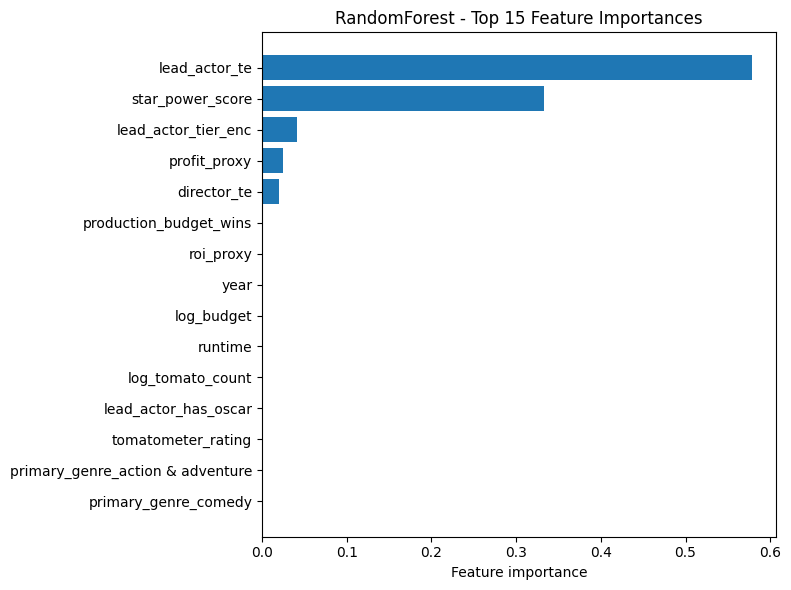

In [ ]:
# Grabbed tuned RF for log_worldwide_gross
rf_best = best_pipes_log["RandomForest"]

# Got feature names after preprocessing
preprocessor = rf_best.named_steps["preprocess"]
model = rf_best.named_steps["model"]

# ColumnTransformer tricks: get numeric + one-hot names
num_features = num_log
cat_features = cat_log

# OneHotEncoder categories
ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
ohe_feature_names = ohe.get_feature_names_out(cat_features)

feature_names = np.concatenate([num_features, ohe_feature_names])

importances = model.feature_importances_
idx = np.argsort(importances)[::-1][:15]  # top 15

plt.figure(figsize=(8, 6))
plt.barh(range(len(idx)), importances[idx][::-1])
plt.yticks(range(len(idx)), [feature_names[i] for i in idx][::-1])
plt.xlabel("Feature importance")
plt.title("RandomForest - Top 15 Feature Importances")
plt.tight_layout()
plt.show()


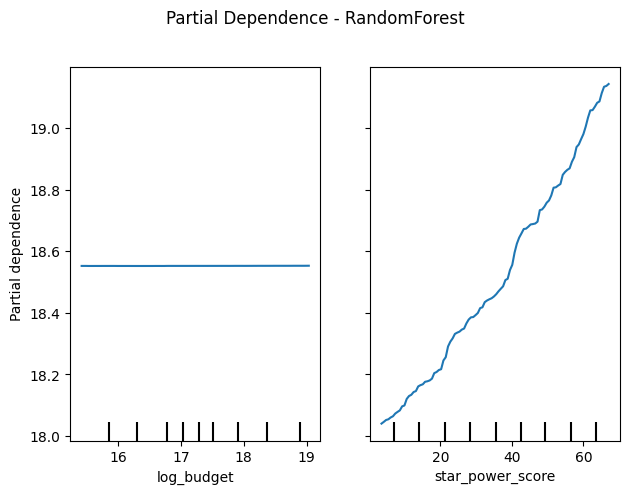

In [ ]:
features_for_pdp = ["log_budget", "star_power_score"]

PartialDependenceDisplay.from_estimator(
    rf_best,
    X_log,
    features=features_for_pdp,
    kind="average",
)
plt.suptitle("Partial Dependence - RandomForest", y=1.02)
plt.tight_layout()
plt.show()


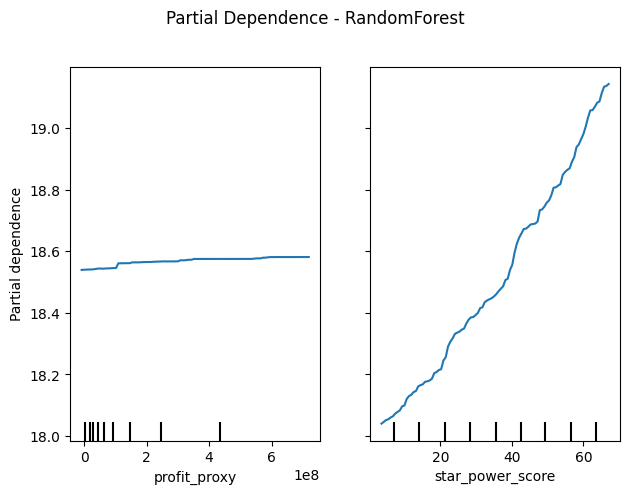

In [ ]:
features_for_pdp = ["profit_proxy", "star_power_score"]

PartialDependenceDisplay.from_estimator(
    rf_best,
    X_log,
    features=features_for_pdp,
    kind="average",
)
plt.suptitle("Partial Dependence - RandomForest", y=1.02)
plt.tight_layout()
plt.show()

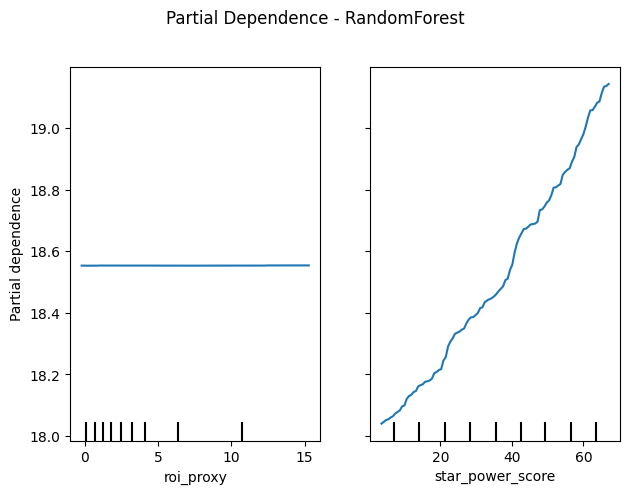

In [ ]:
features_for_pdp = ["roi_proxy", "star_power_score"]

PartialDependenceDisplay.from_estimator(
    rf_best,
    X_log,
    features=features_for_pdp,
    kind="average",
)
plt.suptitle("Partial Dependence - RandomForest", y=1.02)
plt.tight_layout()
plt.show()

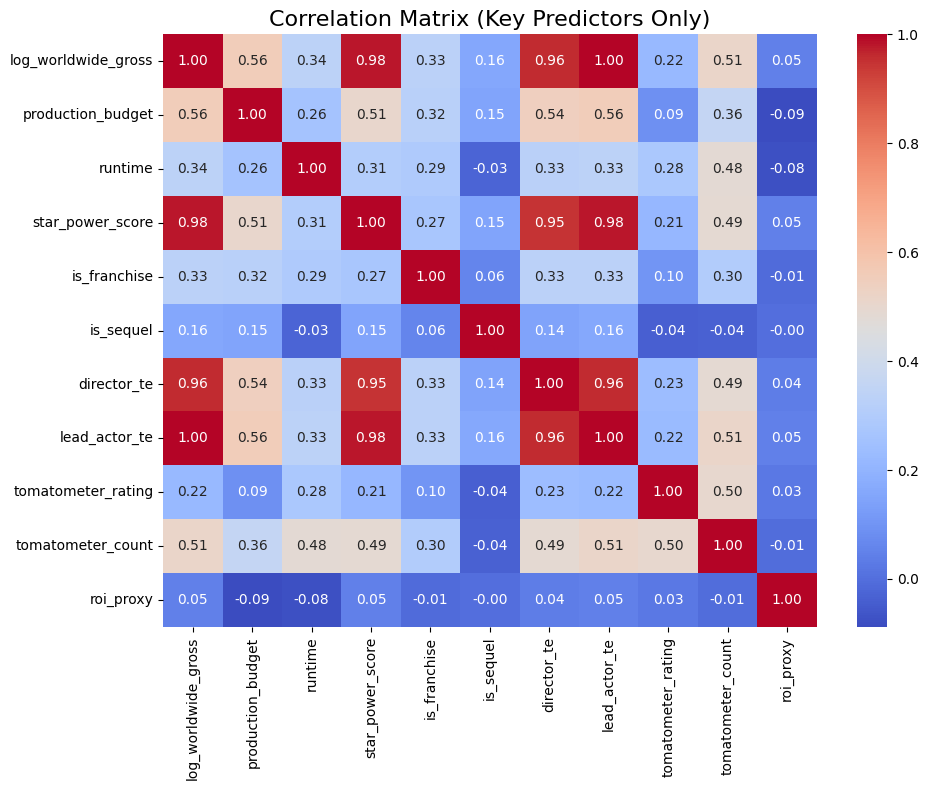

In [ ]:
import seaborn as sns

key_features = [
    "log_worldwide_gross",
    "production_budget", "runtime", "star_power_score",
    "is_franchise", "is_sequel",
    "director_te", "lead_actor_te",
    "tomatometer_rating", "tomatometer_count",
    "roi_proxy"
]

key_features = [c for c in key_features if c in df.columns]

corr_key = df[key_features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_key, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Key Predictors Only)", fontsize=16)
plt.tight_layout()
plt.show()
